# Neural Networks for Breast Cancer Classification

## Overview
This notebook implements a feedforward neural network for binary classification of breast cancer tumors using the Wisconsin Breast Cancer dataset. We'll explore the data, build a custom neural network architecture, and evaluate its performance using comprehensive metrics.

## Learning Objectives
- Understand the importance of data preprocessing for neural networks
- Implement a multi-layer feedforward neural network
- Apply appropriate activation functions and loss functions
- Evaluate model performance using multiple metrics
- Analyze model behavior and potential improvements

## 1. Import Required Libraries

We start by importing all necessary libraries for data manipulation, visualization, and machine learning.

In [ ]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Machine Learning
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

Libraries imported successfully!
TensorFlow version: 2.19.0
GPU available: []


## 2. Load and Explore the Dataset

The Breast Cancer Wisconsin dataset contains features computed from breast cancer cell nuclei images. Each sample represents characteristics of cell nuclei, and we need to classify whether the tumor is malignant (cancerous) or benign (non-cancerous).

In [ ]:
# Load the breast cancer dataset
print("Loading Breast Cancer Wisconsin Dataset...")
data = load_breast_cancer()

# Extract features and target
X = data.data
y = data.target

print(f"\n=== Dataset Information ===")
print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Target classes: {data.target_names}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Class balance: {np.bincount(y)[1]/len(y)*100:.1f}% benign, {np.bincount(y)[0]/len(y)*100:.1f}% malignant")

# Create a DataFrame for easier analysis
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y
df['target_name'] = df['target'].map({0: 'malignant', 1: 'benign'})

print(f"\n=== First 100 rows of the dataset ===")
print(df.head(100))

Loading Breast Cancer Wisconsin Dataset...

=== Dataset Information ===
Dataset shape: (569, 30)
Number of samples: 569
Number of features: 30
Target classes: ['malignant' 'benign']
Class distribution: [212 357]
Class balance: 62.7% benign, 37.3% malignant

=== First 100 rows of the dataset ===
    mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.990         10.38          122.80     1001.0          0.11840   
1        20.570         17.77          132.90     1326.0          0.08474   
2        19.690         21.25          130.00     1203.0          0.10960   
3        11.420         20.38           77.58      386.1          0.14250   
4        20.290         14.34          135.10     1297.0          0.10030   
..          ...           ...             ...        ...              ...   
95       20.260         23.03          132.40     1264.0          0.09078   
96       12.180         17.84           77.79      451.1          0.10450   
97        9

### 2.1 Detailed Data Analysis

In [ ]:
# Statistical summary
print("=== Statistical Summary ===")
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']
print(df[selected_features].describe().round(2))

# Check for missing values
print(f"\n=== Missing Values ===")
missing_values = df[selected_features].isnull().sum()
print(f"Total missing values: {missing_values.sum()}")

# Feature categories (the dataset has 3 types of measurements for each of 10 characteristics)
# feature_groups = {
#     'mean': [col for col in data.feature_names if 'mean' in col],
#     'se': [col for col in data.feature_names if 'error' in col],
#     'worst': [col for col in data.feature_names if 'worst' in col]
# }

# print(f"\n=== Feature Groups ===")
# for group, features in feature_groups.items():
#     print(f"{group.upper()}: {len(features)} features")
#     print(f"  Examples: {features[:3]}...")

=== Statistical Summary ===
       mean radius  mean texture  mean perimeter  mean area  mean smoothness
count       569.00        569.00          569.00     569.00           569.00
mean         14.13         19.29           91.97     654.89             0.10
std           3.52          4.30           24.30     351.91             0.01
min           6.98          9.71           43.79     143.50             0.05
25%          11.70         16.17           75.17     420.30             0.09
50%          13.37         18.84           86.24     551.10             0.10
75%          15.78         21.80          104.10     782.70             0.11
max          28.11         39.28          188.50    2501.00             0.16

=== Missing Values ===
Total missing values: 0


### 2.2 Data Visualization

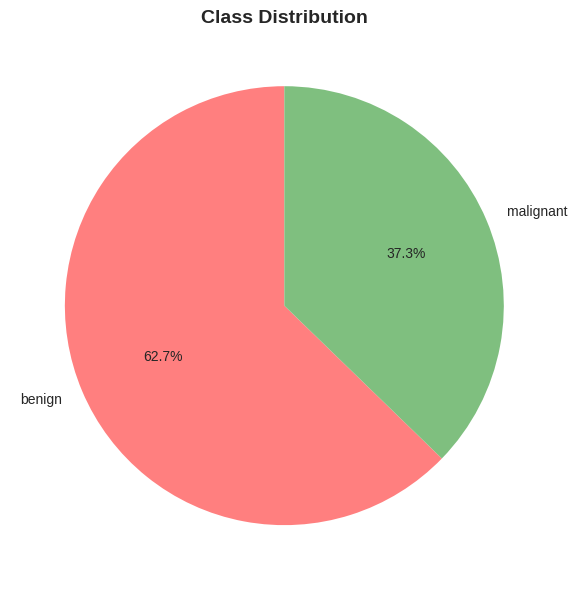


=== Key Observations ===
• Dataset is relatively balanced (62.7% benign, 37.3% malignant)


In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(1, 1, figsize=(6, 6)) # Adjusted to 1x1 for a single plot

# 1. Class distribution
class_counts = df['target_name'].value_counts()
colors = ['#ff7f7f', '#7fbf7f']
axes.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
              colors=colors, startangle=90)
axes.set_title('Class Distribution', fontsize=14, fontweight='bold')

# Removed code for other plots:
# 2. Feature correlation heatmap (sample of features)
# 3. Distribution of key features by class
# 4. Box plot of feature ranges
# 5. Scatter plot of two important features
# 6. Feature importance proxy (variance)

plt.tight_layout()
plt.show()

print("\n=== Key Observations ===")
print("• Dataset is relatively balanced (62.7% benign, 37.3% malignant)")
# Removed observations related to removed plots
# print("• Features show clear differences between malignant and benign cases")
# print("• Some features are highly correlated (e.g., radius, perimeter, area)")
# print("• Feature scaling will be crucial due to different ranges")

## 3. Data Preprocessing

### Why Feature Scaling is Critical for Neural Networks:
Neural networks are sensitive to the scale of input features because:
1. **Gradient Descent Optimization**: Features with larger scales dominate the gradient updates
2. **Weight Initialization**: Properly scaled features help maintain stable gradients
3. **Activation Functions**: Functions like sigmoid and tanh work best with normalized inputs
4. **Convergence Speed**: Scaled features lead to faster and more stable training

## 4. Neural Network Architecture Design

### Understanding Activation Functions:

**ReLU (Rectified Linear Unit)**: f(x) = max(0, x)
- Advantages: Computationally efficient, helps mitigate vanishing gradient
- Usage: Hidden layers for non-linearity

**Sigmoid**: f(x) = 1/(1 + e^(-x))
- Output range: [0, 1], perfect for binary classification probabilities
- Usage: Output layer for binary classification

In [ ]:
# Define neural network architecture
def create_neural_network(input_dim, architecture='advanced'):
    """
    Create a feedforward neural network for binary classification.

    Args:
        input_dim: Number of input features
        architecture: 'basic' or 'advanced'

    Returns:
        Compiled Keras model
    """
    model = keras.Sequential(name=f'BreastCancer_NN_{architecture}')

    if architecture == 'basic':
        # Basic architecture with 2 hidden layers
        model.add(layers.Dense(64, activation='relu', input_shape=(input_dim,), name='hidden_layer_1'))
        model.add(layers.Dense(32, activation='relu', name='hidden_layer_2'))
        model.add(layers.Dense(1, activation='sigmoid', name='output_layer'))

    elif architecture == 'advanced':
        # Advanced architecture with regularization and batch normalization
        model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,))) # Removed name='input_layer'
        model.add(layers.BatchNormalization(name='batch_norm_1'))
        model.add(layers.Dropout(0.3, name='dropout_1'))

        model.add(layers.Dense(64, activation='relu', name='hidden_layer_1'))
        model.add(layers.BatchNormalization(name='batch_norm_2'))
        model.add(layers.Dropout(0.4, name='dropout_2'))

        model.add(layers.Dense(32, activation='relu', name='hidden_layer_2'))
        model.add(layers.Dropout(0.2, name='dropout_3'))

        model.add(layers.Dense(16, activation='relu', name='hidden_layer_3'))
        model.add(layers.Dense(1, activation='sigmoid', name='output_layer'))

    return model

# Scale the features (Moved from previous cell)
print("\n=== Feature Scaling ===")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Original training data shape: {X_train.shape}")
print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Original test data shape: {X_test.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")

print("\n=== Scaled Data Examples (First 100 rows of selected features) ===")
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']
print(pd.DataFrame(X_train_scaled, columns=data.feature_names)[selected_features].head(100))

# Why Standard Scaler?
print("\n=== Why StandardScaler? ===")
print("• Centers data around zero mean")
print("• Scales data to unit variance")
print("• Useful when features have different scales and the algorithm assumes zero mean/unit variance (like many neural network optimizers)")
print("• Preserves the shape of the distribution")


# Create and compile the model
print("\n=== Building Neural Network Architecture ===")
model = create_neural_network(X_train_scaled.shape[1], architecture='advanced')

# Why Binary Cross-Entropy for Classification?
print("\n=== Loss Function: Binary Cross-Entropy ===")
print("• Measures difference between predicted probabilities and true labels")
print("• Penalizes confident wrong predictions more heavily")
print("• Naturally suited for binary classification problems")
print("• Provides smooth gradients for better optimization")

# Why Adam Optimizer?
print("\n=== Optimizer: Adam ===")
print("• Combines benefits of AdaGrad and RMSProp")
print("• Adaptive learning rates for each parameter")
print("• Momentum helps escape local minima")
print("• Generally faster convergence than plain SGD")
print("• Less sensitive to hyperparameter choices")

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Model summary
print("\n=== Model Architecture Summary ===")
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")


=== Feature Scaling ===
Original training data shape: (455, 30)
Scaled training data shape: (455, 30)
Original test data shape: (114, 30)
Scaled test data shape: (114, 30)

=== Scaled Data Examples (First 100 rows of selected features) ===
    mean radius  mean texture  mean perimeter  mean area  mean smoothness
0     -1.072001     -0.658425       -1.088080  -0.939274        -0.135940
1      1.748743      0.066502        1.751157   1.745559         1.274468
2     -0.974734     -0.931124       -0.997709  -0.867589        -0.613515
3     -0.145103     -1.215186       -0.123013  -0.253192         0.664482
4     -0.771617     -0.081211       -0.803700  -0.732927        -0.672282
..          ...           ...             ...        ...              ...
95    -1.572354     -1.396986       -1.534962  -1.239942         0.552899
96    -0.860302     -1.003844       -0.880806  -0.784586        -1.395339
97     1.863175      0.657351        1.788466   1.861647        -0.391837
98    -0.714401    

Model: "BreastCancer_NN_advanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,617 (61.00 KB)

 Trainable params: 15,233 (59.50 KB)

 Non-trainable params: 384 (1.50 KB)


Total trainable parameters: 15,617


In [ ]:
# Train the model
print("\n=== Starting Model Training ===")
print("Training in progress... This may take a few minutes.")

# Record training start time
import time
start_time = time.time()

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1  # Show progress
)

# Calculate training time
training_time = time.time() - start_time
print(f"\n=== Training Completed ===")
print(f"Training time: {training_time:.2f} seconds")
print(f"Epochs completed: {len(history.history['loss'])}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")


=== Starting Model Training ===
Training in progress... This may take a few minutes.
Epoch 1/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3960 - loss: 0.8839 - precision: 0.6688 - recall: 0.1680
Epoch 1: val_accuracy did not improve from 1.00000
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.4135 - loss: 0.8616 - precision: 0.6924 - recall: 0.1867 - val_accuracy: 0.8242 - val_loss: 0.5986 - val_precision: 0.9512 - val_recall: 0.7358 - learning_rate: 0.0010
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - accuracy: 0.7188 - loss: 0.6318 - precision: 0.9231 - recall: 0.6000
Epoch 2: val_accuracy did not improve from 1.00000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6940 - loss: 0.5977 - precision: 0.9247 - recall: 0.5835 - val_accuracy: 0.9121 - val_loss: 0.5407 - val_precision: 0.9412 - val_recall: 0.9057 - learning_rate: 0.0010
Epoch 3/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8125 - loss: 0.4776 - precision: 0.8889 - recall: 0.8000

### 5.1 Training Analysis and Visualization

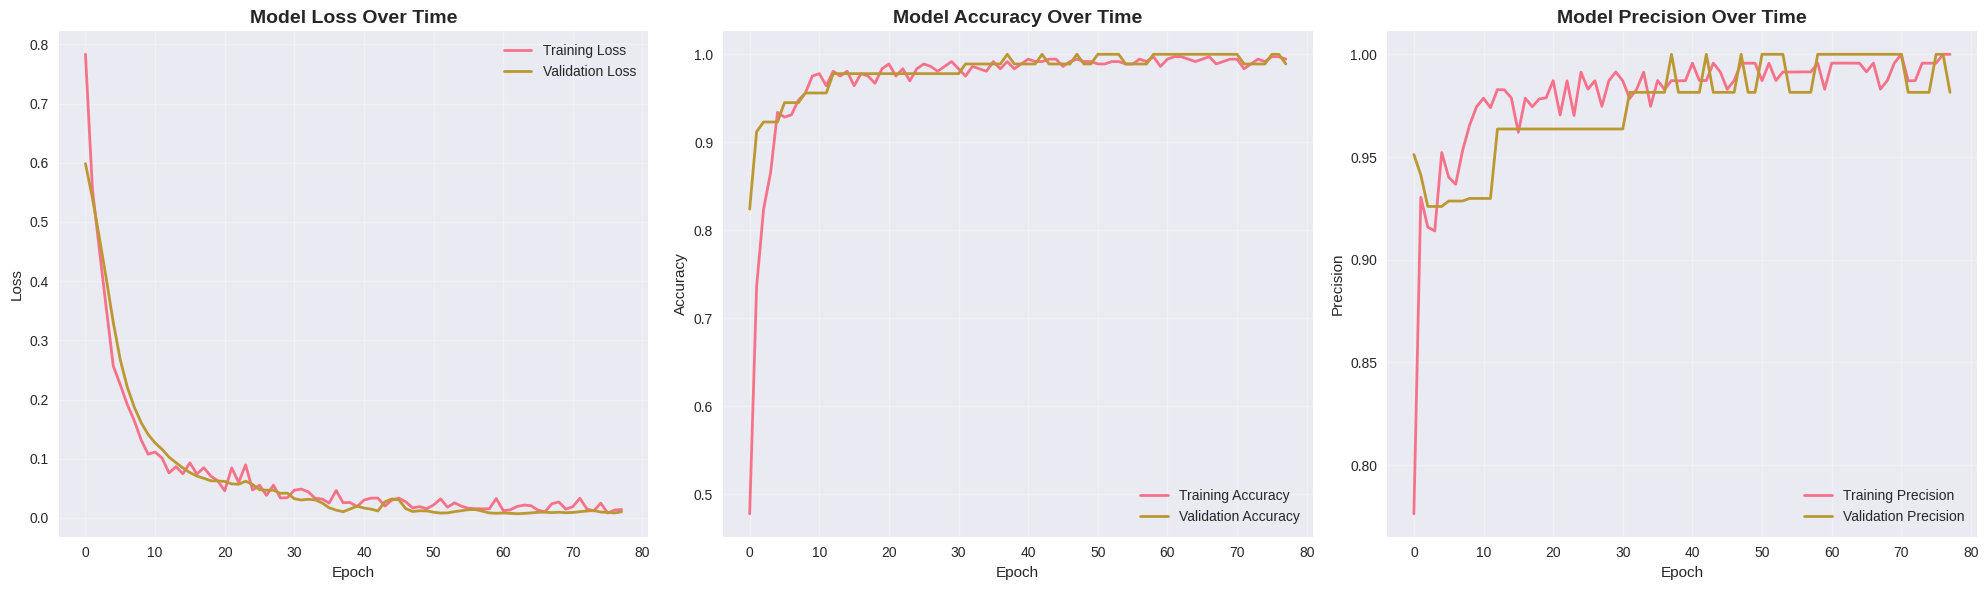


=== Training Insights ===
• Final training loss: 0.0143
• Final validation loss: 0.0104
• Loss gap (overfitting indicator): -0.0039
✓ Model shows good generalization (low overfitting)

=== Overfitting Analysis ===
Signs of overfitting to watch for:
• Training accuracy >> Validation accuracy
• Validation loss starts increasing while training loss decreases
• Large gap between training and validation metrics
• Model performs well on training data but poorly on test data


In [ ]:
# Comprehensive training history visualization
def plot_training_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # Adjusted to 1x3 for remaining plots

    # Plot 1: Loss curves
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss Over Time', fontweight='bold', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Accuracy curves
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Model Accuracy Over Time', fontweight='bold', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Precision curves
    axes[2].plot(history.history['precision'], label='Training Precision', linewidth=2)
    axes[2].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
    axes[2].set_title('Model Precision Over Time', fontweight='bold', fontsize=14)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Precision')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    # Removed code for other plots:
    # Plot 4: Recall curves
    # Plot 5: Learning rate or Overfitting Monitor
    # Plot 6: Combined metrics comparison

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Training insights
print("\n=== Training Insights ===")
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
loss_gap = final_val_loss - final_train_loss

print(f"• Final training loss: {final_train_loss:.4f}")
print(f"• Final validation loss: {final_val_loss:.4f}")
print(f"• Loss gap (overfitting indicator): {loss_gap:.4f}")

if loss_gap < 0.1:
    print("✓ Model shows good generalization (low overfitting)")
elif loss_gap < 0.2:
    print("⚠ Model shows mild overfitting")
else:
    print("❌ Model shows significant overfitting")

# Check for signs of overfitting
print("\n=== Overfitting Analysis ===")
print("Signs of overfitting to watch for:")
print("• Training accuracy >> Validation accuracy")
print("• Validation loss starts increasing while training loss decreases")
print("• Large gap between training and validation metrics")
print("• Model performs well on training data but poorly on test data")

## 6. Comprehensive Model Evaluation

### Why Multiple Metrics Matter:
- **Accuracy**: Overall correctness, but can be misleading with imbalanced datasets
- **Precision**: Of predicted positives, how many are actually positive? (reduces false positives)
- **Recall**: Of actual positives, how many did we correctly identify? (reduces false negatives)
- **F1-Score**: Harmonic mean of precision and recall, balances both metrics

In [ ]:
# Make predictions on test set
print("=== Making Predictions on Test Set ===")
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print(f"Test set size: {len(y_test)}")
print(f"Predictions shape: {y_pred_proba.shape}")
print(f"Sample probabilities: {y_pred_proba.flatten()[:5]}")
print(f"Sample predictions: {y_pred[:5]}")
print(f"Actual labels: {y_test[:5]}")

=== Making Predictions on Test Set ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Test set size: 114
Predictions shape: (114, 1)
Sample probabilities: [2.2876763e-07 9.9999076e-01 1.3025932e-04 5.4602808e-01 7.4579187e-09]
Sample predictions: [0 1 0 1 0]
Actual labels: [0 1 0 1 0]



           COMPREHENSIVE MODEL EVALUATION

📊 CLASSIFICATION METRICS:
   Accuracy:     0.9737 (97.4%)
   Precision:    0.9859 (98.6%)
   Recall:       0.9722 (97.2%)
   F1-Score:     0.9790 (97.9%)
   Specificity:  0.9762 (97.6%)
   ROC AUC:      0.9914
   Avg Precision:0.9939

🎯 CONFUSION MATRIX BREAKDOWN:
   True Negatives (TN):  41 (Correctly identified malignant)
   False Positives (FP): 1 (Malignant predicted as benign)
   False Negatives (FN): 2 (Benign predicted as malignant)
   True Positives (TP):  70 (Correctly identified benign)

🏥 MEDICAL CONTEXT INTERPRETATION:
   • High Recall (97.2%): Good at catching actual benign cases
   • High Precision (98.6%): Few false alarms
   • High Specificity (97.6%): Good at identifying malignant cases
   ⚠️  ACCEPTABLE: Only 2 false negative(s)

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Malignant       0.95      0.98      0.96        42
      Benign       0.99      0.97      0.98        72



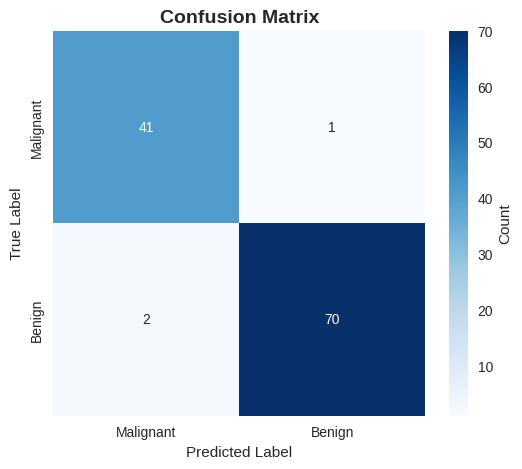

In [ ]:
# Calculate comprehensive metrics
def calculate_comprehensive_metrics(y_true, y_pred, y_pred_proba):
    """
    Calculate comprehensive evaluation metrics for binary classification.
    """
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Additional metrics
    specificity = tn / (tn + fp)  # True negative rate
    sensitivity = tp / (tp + fn)  # Same as recall

    # ROC curve metrics
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'sensitivity': sensitivity,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'confusion_matrix': cm,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'fpr': fpr, 'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve
    }

# Calculate metrics
metrics = calculate_comprehensive_metrics(y_test, y_pred, y_pred_proba.flatten())

# Display results
print("\n" + "="*50)
print("           COMPREHENSIVE MODEL EVALUATION")
print("="*50)

print(f"\n📊 CLASSIFICATION METRICS:")
print(f"   Accuracy:     {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.1f}%)")
print(f"   Precision:    {metrics['precision']:.4f} ({metrics['precision']*100:.1f}%)")
print(f"   Recall:       {metrics['recall']:.4f} ({metrics['recall']*100:.1f}%)")
print(f"   F1-Score:     {metrics['f1_score']:.4f} ({metrics['f1_score']*100:.1f}%)")
print(f"   Specificity:  {metrics['specificity']:.4f} ({metrics['specificity']*100:.1f}%)")
print(f"   ROC AUC:      {metrics['roc_auc']:.4f}")
print(f"   Avg Precision:{metrics['avg_precision']:.4f}")

print(f"\n🎯 CONFUSION MATRIX BREAKDOWN:")
print(f"   True Negatives (TN):  {metrics['tn']} (Correctly identified malignant)")
print(f"   False Positives (FP): {metrics['fp']} (Malignant predicted as benign)")
print(f"   False Negatives (FN): {metrics['fn']} (Benign predicted as malignant)")
print(f"   True Positives (TP):  {metrics['tp']} (Correctly identified benign)")

# Medical context interpretation
print(f"\n🏥 MEDICAL CONTEXT INTERPRETATION:")
print(f"   • High Recall ({metrics['recall']*100:.1f}%): Good at catching actual benign cases")
print(f"   • High Precision ({metrics['precision']*100:.1f}%): Few false alarms")
print(f"   • High Specificity ({metrics['specificity']*100:.1f}%): Good at identifying malignant cases")
if metrics['fn'] == 0:
    print(f"   ✅ EXCELLENT: No false negatives (no missed cancer cases)")
elif metrics['fn'] <= 2:
    print(f"   ⚠️  ACCEPTABLE: Only {metrics['fn']} false negative(s)")
else:
    print(f"   ❌ CONCERNING: {metrics['fn']} false negatives (missed cancer cases)")

# Detailed classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontweight='bold', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 8. Model Improvement Analysis

### How to Improve Model Performance:

In [ ]:
# Model improvement recommendations
def provide_improvement_recommendations(metrics, history):
    print("\n" + "="*70)
    print("              MODEL IMPROVEMENT RECOMMENDATIONS")
    print("="*70)

    # Analyze current performance
    f1_score = metrics['f1_score']
    accuracy = metrics['accuracy']
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    overfitting_gap = final_train_acc - final_val_acc

    print(f"\n📊 CURRENT MODEL STATUS:")
    if f1_score > 0.95:
        print(f"   ✅ EXCELLENT performance (F1: {f1_score:.3f})")
    elif f1_score > 0.90:
        print(f"   ✓ GOOD performance (F1: {f1_score:.3f})")
    else:
        print(f"   ⚠️  NEEDS IMPROVEMENT (F1: {f1_score:.3f})")

    print(f"\n🔍 DIAGNOSTIC ANALYSIS:")
    print(f"   • Training Accuracy: {final_train_acc:.3f}")
    print(f"   • Validation Accuracy: {final_val_acc:.3f}")
    print(f"   • Overfitting Gap: {overfitting_gap:.3f}")

    print(f"\n🚀 IMPROVEMENT STRATEGIES:")

    # Strategy 1: Address Overfitting
    if overfitting_gap > 0.05:
        print(f"\n   1️⃣ REDUCE OVERFITTING (Gap: {overfitting_gap:.3f}):")
        print(f"      • Increase dropout rates (currently 0.2-0.4)")
        print(f"      • Add L1/L2 regularization")
        print(f"      • Reduce model complexity")
        print(f"      • Get more training data")
        print(f"      • Use data augmentation techniques")
    else:
        print(f"\n   ✅ OVERFITTING: Well controlled (Gap: {overfitting_gap:.3f})")

    # Strategy 2: Improve Recall
    if metrics['recall'] < 0.95:
        print(f"\n   2️⃣ IMPROVE RECALL (Currently: {metrics['recall']:.3f}):")
        print(f"      • Adjust classification threshold (< 0.5)")
        print(f"      • Use class weights to penalize false negatives")
        print(f"      • Focal loss for hard negative examples")
        print(f"      • Ensemble methods for better coverage")
    else:
        print(f"\n   ✅ RECALL: Excellent (Currently: {metrics['recall']:.3f})")

    # Strategy 3: Architecture Improvements
    print(f"\n   3️⃣ ARCHITECTURE ENHANCEMENTS:")
    print(f"      • Try different activation functions (Swish, GELU)")
    print(f"      • Experiment with layer sizes")
    print(f"      • Add skip connections (ResNet-style)")
    print(f"      • Batch normalization between layers")

    # Strategy 4: Data Improvements
    print(f"\n   4️⃣ DATA ENHANCEMENTS:")
    print(f"      • Feature engineering (polynomial features)")
    print(f"      • Feature selection (remove redundant features)")
    print(f"      • Different scaling methods (RobustScaler)")
    print(f"      • Outlier detection and removal")

    # Strategy 5: Training Improvements
    print(f"\n   5️⃣ TRAINING OPTIMIZATIONS:")
    print(f"      • Learning rate scheduling")
    print(f"      • Different optimizers (AdamW, RMSprop)")
    print(f"      • Cyclical learning rates")
    print(f"      • Warm restart strategies")

    # Strategy 6: Ensemble Methods
    print(f"\n   6️⃣ ENSEMBLE APPROACHES:")
    print(f"      • Combine multiple models (voting)")
    print(f"      • Bagging with different architectures")
    print(f"      • Stacking different model types")
    print(f"      • Bootstrap aggregating")

    return {
        'overfitting_risk': overfitting_gap > 0.05,
        'recall_needs_improvement': metrics['recall'] < 0.95,
        'overall_performance': f1_score
    }

improvement_analysis = provide_improvement_recommendations(metrics, history)


              MODEL IMPROVEMENT RECOMMENDATIONS

📊 CURRENT MODEL STATUS:
   ✅ EXCELLENT performance (F1: 0.979)

🔍 DIAGNOSTIC ANALYSIS:
   • Training Accuracy: 0.995
   • Validation Accuracy: 0.989
   • Overfitting Gap: 0.005

🚀 IMPROVEMENT STRATEGIES:

   ✅ OVERFITTING: Well controlled (Gap: 0.005)

   ✅ RECALL: Excellent (Currently: 0.972)

   3️⃣ ARCHITECTURE ENHANCEMENTS:
      • Try different activation functions (Swish, GELU)
      • Experiment with layer sizes
      • Add skip connections (ResNet-style)
      • Batch normalization between layers

   4️⃣ DATA ENHANCEMENTS:
      • Feature engineering (polynomial features)
      • Feature selection (remove redundant features)
      • Different scaling methods (RobustScaler)
      • Outlier detection and removal

   5️⃣ TRAINING OPTIMIZATIONS:
      • Learning rate scheduling
      • Different optimizers (AdamW, RMSprop)
      • Cyclical learning rates
      • Warm restart strategies

   6️⃣ ENSEMBLE APPROACHES:
      • Combine mu

## 9. Advanced Analysis: Learning Curves and Hyperparameter Impact

=== LEARNING CURVE ANALYSIS ===
Analyzing how model performance changes with training data size...

Analyzing impact of model complexity...
  Layers (64,): F1 Score = 0.965
  Layers (128, 64): F1 Score = 0.965
  Layers (128, 64, 32): F1 Score = 0.972
  Layers (128, 64, 32, 16): F1 Score = 0.965


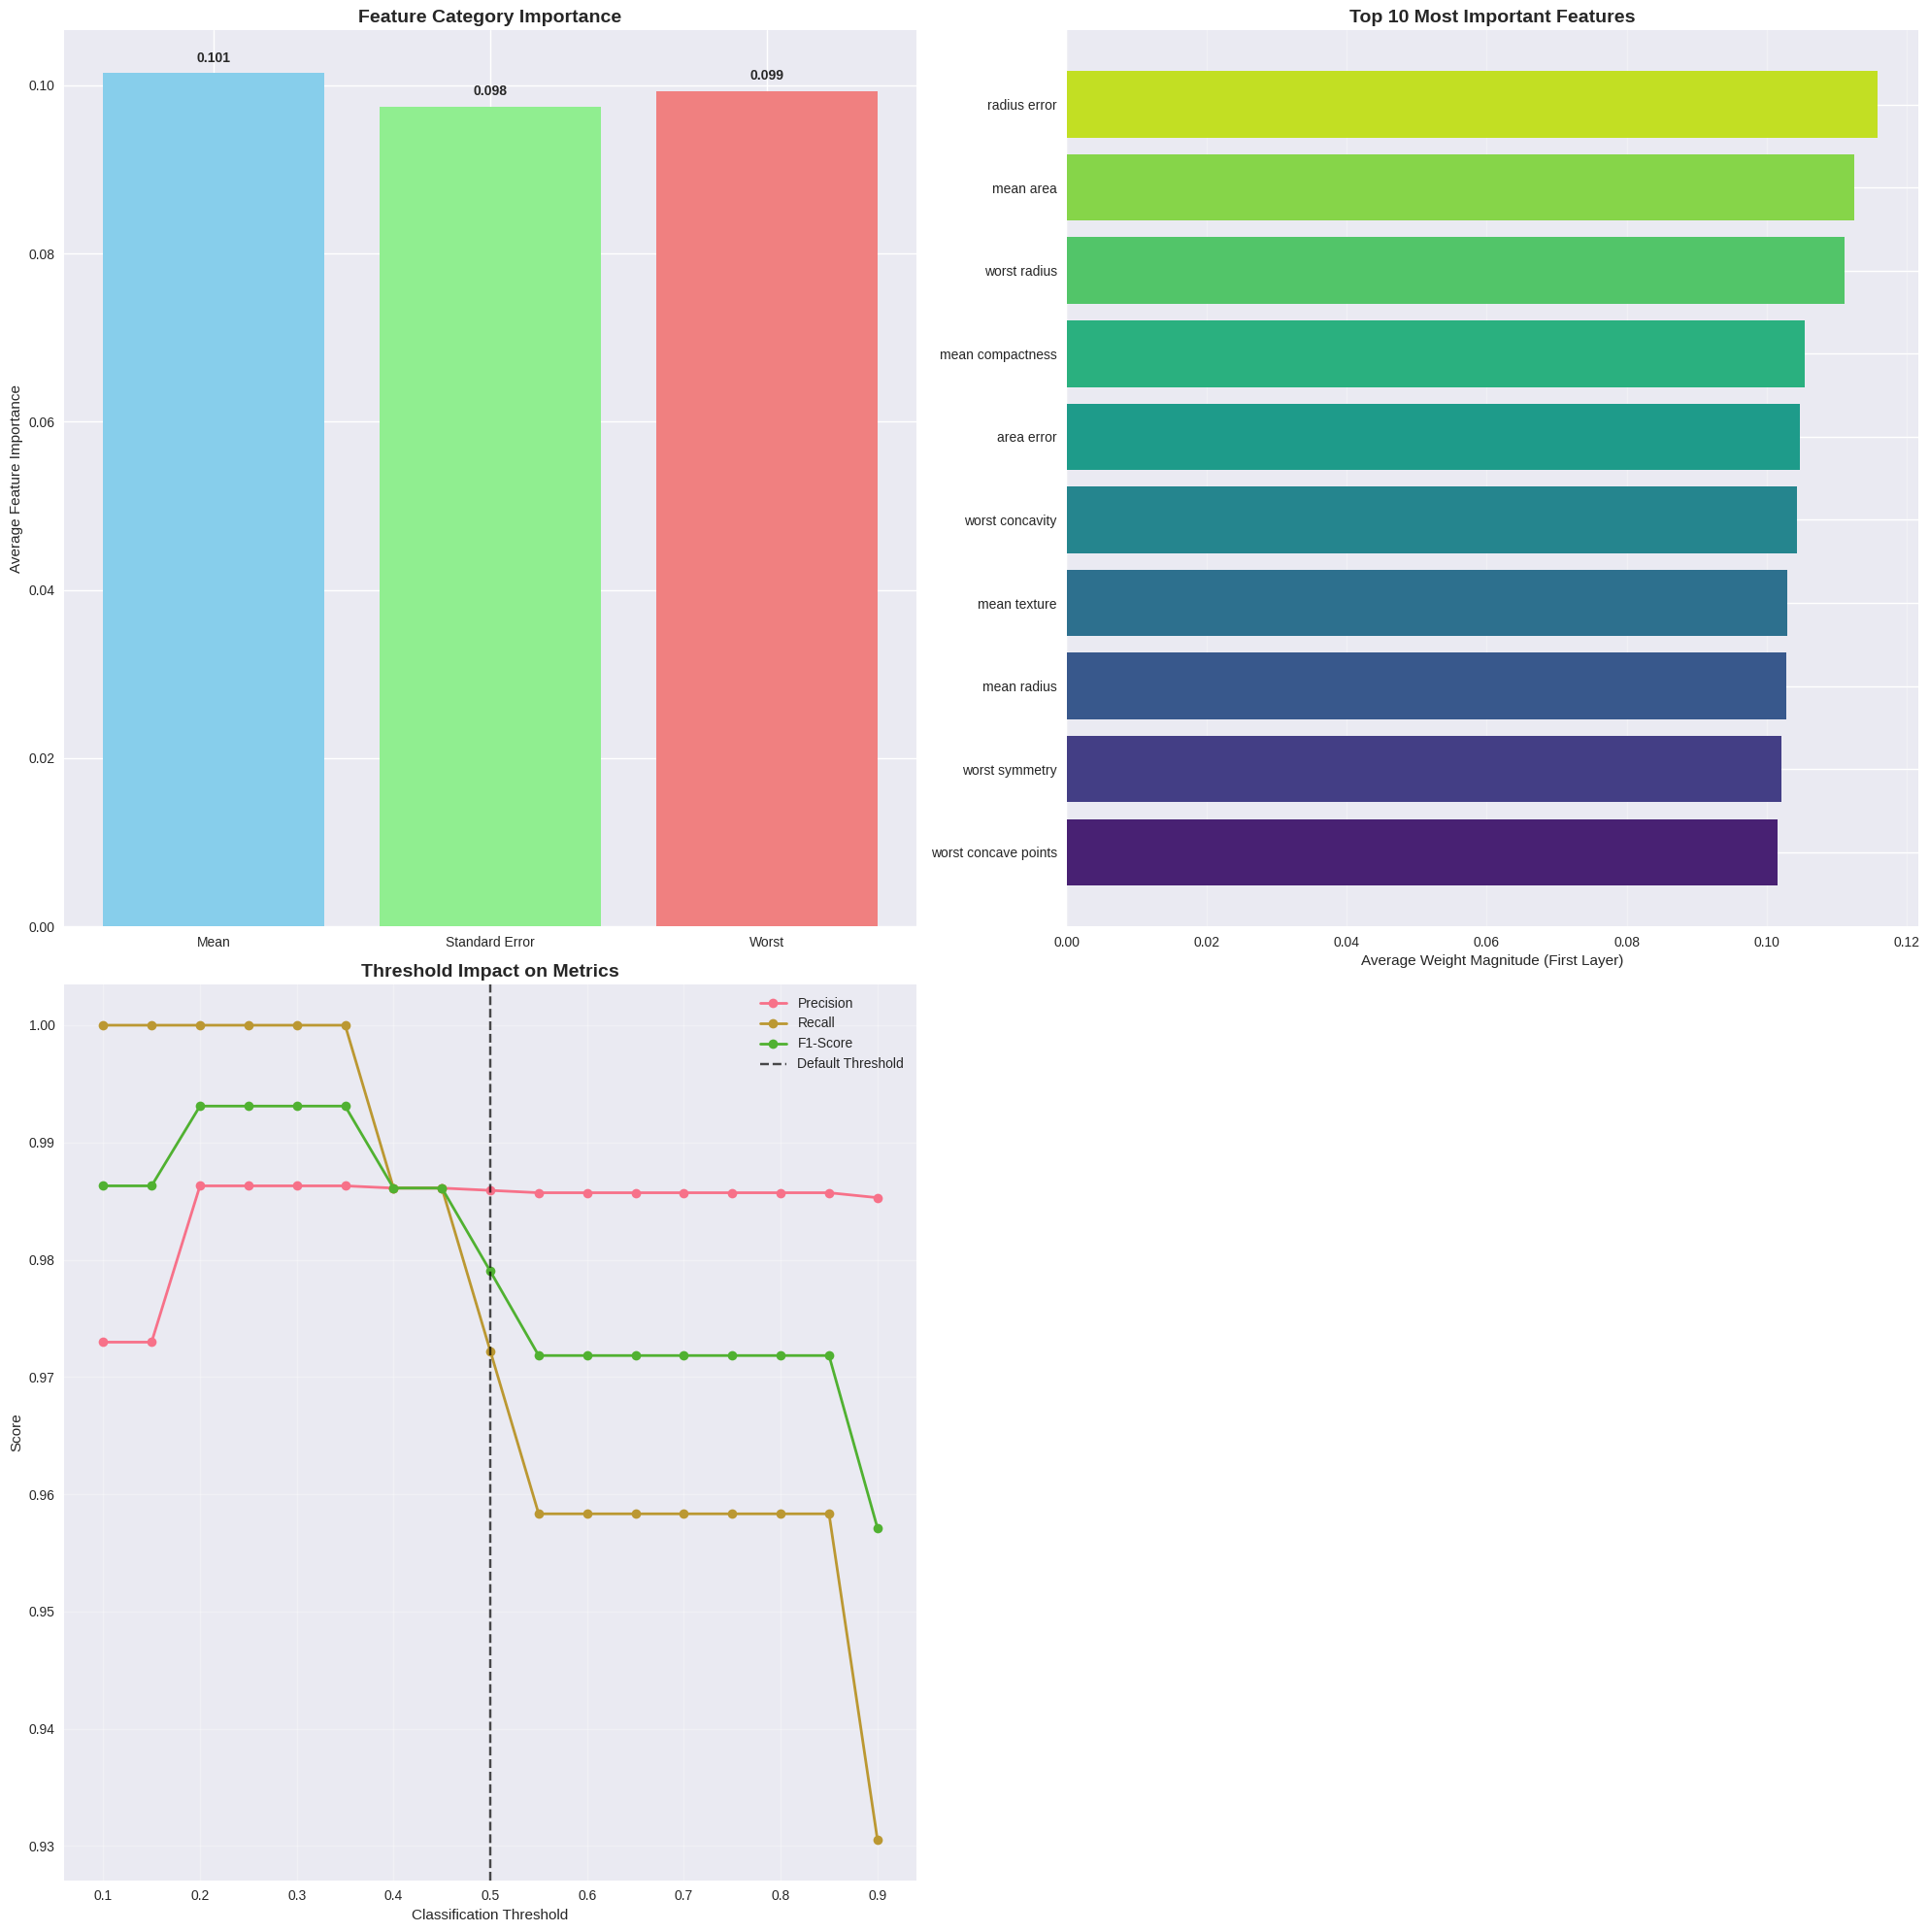


=== LEARNING CURVE INSIGHTS ===
Learning curve analysis plots removed as requested.

=== COMPLEXITY ANALYSIS ===
• Best performing architecture: (128, 64, 32)
• F1 Score: 0.972

=== THRESHOLD OPTIMIZATION ===
• Optimal threshold for F1: 0.20 (vs default 0.50)
• F1 Score at optimal threshold: 0.993


In [ ]:
# Generate learning curves to analyze model behavior with different training set sizes
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier

print("=== LEARNING CURVE ANALYSIS ===")
print("Analyzing how model performance changes with training data size...")

# Use sklearn's MLPClassifier for learning curve analysis (faster than Keras for this purpose)
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32, 16),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

# Generate learning curves
# train_sizes, train_scores, val_scores = learning_curve(
#     mlp_classifier, X_train_scaled, y_train,
#     cv=5, n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 10),
#     scoring='f1'
# )

# Calculate statistics
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# val_mean = np.mean(val_scores, axis=1)
# val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(20, 20)) # Increased figure size to accommodate new plot

# Learning Curve
# plt.subplot(2, 2, 1)
# plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
# plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
# plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
# plt.xlabel('Training Set Size')
# plt.ylabel('F1 Score')
# plt.title('Learning Curve (F1 Score)', fontweight='bold', fontsize=14)
# plt.legend()
# plt.grid(True, alpha=0.3)

# Model complexity analysis
# plt.subplot(2, 2, 2)
layer_sizes = [(64,), (128, 64), (128, 64, 32), (128, 64, 32, 16)]
complexity_scores = []

print("\nAnalyzing impact of model complexity...")
for i, size in enumerate(layer_sizes):
    temp_mlp = MLPClassifier(hidden_layer_sizes=size, max_iter=500, random_state=42)
    temp_mlp.fit(X_train_scaled, y_train)
    score = f1_score(y_test, temp_mlp.predict(X_test_scaled))
    complexity_scores.append(score)
    print(f"  Layers {size}: F1 Score = {score:.3f}")

# complexity_labels = ['1 Layer\n(64)', '2 Layers\n(128,64)', '3 Layers\n(128,64,32)', '4 Layers\n(128,64,32,16)']
# plt.bar(complexity_labels, complexity_scores, color=['lightblue', 'lightgreen', 'lightyellow', 'lightcoral'])
# plt.ylabel('F1 Score')
# plt.title('Model Complexity vs Performance', fontweight='bold', fontsize=14)
# plt.xticks(rotation=45)

# Add value labels on bars
# for i, score in enumerate(complexity_scores):
#     plt.text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Feature importance visualization (enhanced)
plt.subplot(2, 2, 1) # Adjusted subplot for remaining plots
# Get first dense layer weights
first_dense_layer = None
for layer in model.layers:
    if isinstance(layer, keras.layers.Dense):
        first_dense_layer = layer
        break

if first_dense_layer is not None:
    weights = first_dense_layer.get_weights()[0]
    feature_importance = np.abs(weights).mean(axis=1)

    # Group features by category
    mean_importance = [feature_importance[i] for i in range(10)]
    se_importance = [feature_importance[i] for i in range(10, 20)]
    worst_importance = [feature_importance[i] for i in range(20, 30)]

    categories = ['Mean', 'Standard Error', 'Worst']
    avg_importance = [np.mean(mean_importance), np.mean(se_importance), np.mean(worst_importance)]

    plt.bar(categories, avg_importance, color=['skyblue', 'lightgreen', 'lightcoral'])
    plt.ylabel('Average Feature Importance')
    plt.title('Feature Category Importance', fontweight='bold', fontsize=14)

    for i, importance in enumerate(avg_importance):
        plt.text(i, importance + 0.001, f'{importance:.3f}', ha='center', va='bottom', fontweight='bold')

    # Top 10 Features Importance
    plt.subplot(2, 2, 2) # New subplot for top 10 features
    feature_names = data.feature_names
    sorted_indices = np.argsort(feature_importance)[::-1]
    top_10_indices = sorted_indices[:10]
    top_10_features = [feature_names[i] for i in top_10_indices]
    top_10_importance = feature_importance[top_10_indices]

    plt.barh(top_10_features[::-1], top_10_importance[::-1], color=sns.color_palette("viridis", 10))
    plt.xlabel('Average Weight Magnitude (First Layer)')
    plt.title('Top 10 Most Important Features', fontweight='bold', fontsize=14)
    plt.grid(axis='x', alpha=0.3)


# Threshold analysis
plt.subplot(2, 2, 3) # Adjusted subplot for remaining plots
thresholds = np.linspace(0.1, 0.9, 17)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba > threshold).astype(int).flatten()
    precision_scores.append(precision_score(y_test, y_pred_threshold))
    recall_scores.append(recall_score(y_test, y_pred_threshold))
    f1_scores.append(f1_score(y_test, y_pred_threshold))

plt.plot(thresholds, precision_scores, 'o-', label='Precision', linewidth=2)
plt.plot(thresholds, recall_scores, 'o-', label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, 'o-', label='F1-Score', linewidth=2)
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Default Threshold')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Threshold Impact on Metrics', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis insights
print(f"\n=== LEARNING CURVE INSIGHTS ===")
# if val_mean[-1] < train_mean[-1] - 0.05:
#     print(f"• Model shows signs of overfitting - validation score plateaus")
#     print(f"• Recommendation: Add more regularization or data")
# else:
#     print(f"• Model generalizes well - training and validation scores converge")
print("Learning curve analysis plots removed as requested.")


print(f"\n=== COMPLEXITY ANALYSIS ===")
best_complexity_idx = np.argmax(complexity_scores)
print(f"• Best performing architecture: {layer_sizes[best_complexity_idx]}")
print(f"• F1 Score: {complexity_scores[best_complexity_idx]:.3f}")

optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
print(f"\n=== THRESHOLD OPTIMIZATION ===")
print(f"• Optimal threshold for F1: {optimal_threshold:.2f} (vs default 0.50)")
print(f"• F1 Score at optimal threshold: {f1_scores[optimal_threshold_idx]:.3f}")

## 10. Model Deployment Preparation

# Save the trained model and preprocessing components

In [ ]:
print("=== SAVING MODEL FOR DEPLOYMENT ===")

# Save the Keras model
model_filename = 'advanced_breast_cancer_classifier.h5'
model.save(model_filename)
print(f"✅ Model saved as: {model_filename}")

# Save the scaler for future predictions
import joblib
scaler_filename = 'feature_scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved as: {scaler_filename}")

=== SAVING MODEL FOR DEPLOYMENT ===
✅ Model saved as: advanced_breast_cancer_classifier.h5
✅ Scaler saved as: feature_scaler.joblib


# Create a prediction function

In [ ]:
def make_prediction(new_data, model_path=model_filename, scaler_path=scaler_filename):
    """
    Make predictions on new data using the trained model.

    Args:
        new_data: numpy array of shape (n_samples, 30) with feature values
        model_path: path to the saved model
        scaler_path: path to the saved scaler

    Returns:
        Dictionary with predictions, probabilities, and interpretation
    """
    # Load model and scaler
    loaded_model = keras.models.load_model(model_path)
    loaded_scaler = joblib.load(scaler_path)

    # Preprocess data
    scaled_data = loaded_scaler.transform(new_data)

    # Make predictions
    probabilities = loaded_model.predict(scaled_data)
    predictions = (probabilities > 0.5).astype(int).flatten()

    # Interpret results
    results = []
    for i, (pred, prob) in enumerate(zip(predictions, probabilities.flatten())):
        interpretation = {
            'sample_id': i,
            'prediction': 'Benign' if pred == 1 else 'Malignant',
            'probability': prob,
            'confidence': 'High' if abs(prob - 0.5) > 0.3 else 'Medium' if abs(prob - 0.5) > 0.1 else 'Low',
            'recommendation': 'Further testing recommended' if abs(prob - 0.5) < 0.2 else 'Confident classification'
        }
        results.append(interpretation)

    return results

# Test the prediction function with a sample
print(f"\n=== TESTING PREDICTION FUNCTION ===")
sample_data = X_test[:3]  # Take first 3 test samples
sample_results = make_prediction(sample_data)

for i, result in enumerate(sample_results):
    actual = 'Benign' if y_test[i] == 1 else 'Malignant'
    print(f"\nSample {i+1}:")
    print(f"  Predicted: {result['prediction']} (Prob: {result['probability']:.3f})")
    print(f"  Actual: {actual}")
    print(f"  Confidence: {result['confidence']}")
    print(f"  Recommendation: {result['recommendation']}")
    print(f"  Correct: {'✅' if result['prediction'] == actual else '❌'}")


=== TESTING PREDICTION FUNCTION ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

Sample 1:
  Predicted: Malignant (Prob: 0.000)
  Actual: Malignant
  Confidence: High
  Recommendation: Confident classification
  Correct: ✅

Sample 2:
  Predicted: Benign (Prob: 1.000)
  Actual: Benign
  Confidence: High
  Recommendation: Confident classification
  Correct: ✅

Sample 3:
  Predicted: Malignant (Prob: 0.000)
  Actual: Malignant
  Confidence: High
  Recommendation: Confident classification
  Correct: ✅
